# Q-Learning

O algoritmo de Q-Learning é um dos algoritmos do grupo TD (Temporal difference, diferença temporal), que estimam a função de valor por meio de uma estimativa a partir de outra estimativa, processo chamado _bootstrapping_.

## Motivação

Assim como nos métodos de Monte Carlo, os métodos TD tem vantagens sobre os métodos de Programação Dinâmica (DP) por não dependerem de um modelo do ambiente para seu funcionamento, sendo capazes de aprender diretamente com a experiência.

No entanto, os métodos TD têm uma vantagem sobre os métodos de Monte Carlo (MC), pois são capazes de aprendizado _online_, ou seja, aprendem com a passagem do episódio, enquanto os métodos de MC precisam chegar no final do episódio para iniciar o aprendizado. Em episódios longos ou em ambientes que não estão divididos em episódios, os métodos MC se tornam inviáveis.

## Teoria

O objetivo do algoritmo é encontrar a função de *Valor Estado-Ação* da política ótima, ou seja, a função que melhor representa os valores *q* para cada par estado-ação do ambiente. A equação da função se encontra abaixo, onde o valor q é dado pelo valor esperado do retorno G, dado um par estado-ação:

![funcao q](https://camo.githubusercontent.com/003498f344a099b4d34d45aa2bc0841e562fa01e/68747470733a2f2f6c617465782e636f6465636f67732e636f6d2f6769662e6c617465783f715f5c706928732c61292673706163653b3d2673706163653b5c6d6174686f707b5c6d61746862627b457d5f5c70697d5b7b475f747d7c7b535f743d732c2673706163653b415f743d617d5d)

O algoritmo de Q-Learning é extremamente versátil dentro dos métodos TD, por ser um algoritmo _off-policy_, ou seja, seu aprendizado não depende da política que está sendo seguida, diferente de outros métodos TD, como SARSA. Com isso, o treinamento é mais eficiente, pois pode usar experiências armazenadas em seu treinamento, não somente o que o agente está observando no episódio em si.

## Política

A política adotada é a chamada ε-greedy (ε-guloso). Um número aleatório no intervalo entre 0 e 1 é comparado com ε. Se o número aleatório for menor do que o valor de ε, a ação tomada vai ser aleatória, de forma a explorar o ambiente. Caso contrário, a ação vai ser a que possui maior valor Q, de acordo com as estimativas atuais que o algoritmo possui. Dessa forma, o agente tomará uma ação aleatória com probabilidade ε.

## Algoritmo

O algoritmo consiste na atualização das estimativas dos valores Q(S, A) de acordo com a seguinte expressão:

<img src="https://latex.codecogs.com/svg.latex?Q(S,&space;A)&space;\leftarrow&space;Q(S,&space;A)&space;&plus;&space;\alpha&space;[R&space;&plus;&space;\gamma&space;\max_{a}Q(S',&space;a)&space;-&space;Q(S,&space;A)]" title="Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma \max_{a}Q(S', a) - Q(S, A)]" />

De forma resumida, o valor Q(S,A) é atualizado fazendo uma "correção" com "taxa de aprendizado" &alpha;, considerando a recompensa R recebida com a escolha da ação e a ação futura que maximiza o valor Q do próximo estado (S'), descontada de um fator &gamma;. É interessante ressaltar que todas as atualizações são feitas com as estimativas, tanto do presente quanto do futuro, que vão se aprimorando até se aproximar da função q da política ótima. É possível enxergar a expressão que multiplica &alpha; como um erro, pois temos R + &gamma; maxQ(S', a) como nosso _objetivo_ e Q(S, a) nossa _estimativa_. A diferença dos dois fatores é portanto um erro. No contexto de algoritmos TD, este erro é chamado _TD-error_.

O funcionamento do algoritmo ao longo dos episódios pode ser visto no pseudocódigo a seguir:

![Algoritmo de Q-Learning](imgs/q-learning.svg)

## Código


Inicialmente, iremos definir a classe do nosso agente, com as principais funções necessárias para seu funcionamento.

In [1]:
import numpy as np

class QLearningAgent:
    """
    Classe do agente que seguirá o algoritmo de Q-Learning
    """
    def __init__(self, epsilon, decay, epsilon_min, alpha, gamma, n_actions):
        """
        Inicializa os parâmetros do algoritmo, assim como a  'tabela' Q

         Parâmetros
        ----------
        epsilon: float
            Probabilidade de tomar ação aleatória.
        decay: float
            Taxa de decaimento do epsilon por episódio.
        epsilon_min: float
            Valor mínimo de epsilon.
        alpha: float
            Taxa de aprendizado.
        gamma: float
            Fator de desconto.
        n_actions: int
            Número de ações possíveis no ambiente
        """

        self.Q = {} #tabela Q
        self.n_actions = n_actions #número possível de ações, fornecido pelo env

        # parâmetros para o epsilon-decay
        self.epsilon = epsilon #epsilon inicial
        self.decay = decay #taxa de decaimento
        self.epsilon_min = epsilon_min #epsilon minimo

        self.alpha = alpha #taxa de aprendizado
        self.gamma = gamma #peso das recompensas futuras

    def choose_action(self, env, state):
        """
        Escolhe a ação do agente, de acordo com a política epsilon-greedy
        
        Parâmetros
        ----------
        env: Environment
            Ambiente sendo utilizado.
        state: np.array
            Estado atual do agente

        Retorna
        ----------
        action: int
            Ação a ser tomada.
        """
        if state not in self.Q.keys(): #acrescenta estado na tabela
            self.Q[state] = [0] * self.n_actions

        if np.random.random() < self.epsilon:
            action = env.action_space.sample() #ação aleatória
        else:
            action = np.argmax(self.Q[state]) #melhor ação
        return action

    def epsilon_decay(self):
        """
        Função que faz o decaimento de epsilon a cada episódio
        """
        self.epsilon = max(self.epsilon*self.decay, self.epsilon_min)

    def updates_Q(self, state, action, next_state, reward):
        """
        Função que atualiza a tabela Q, de acordo com a equação do Q-Learning
        """
        if state not in self.Q.keys():
            self.Q[state] = [0] * self.n_actions
        if next_state not in self.Q.keys():
            self.Q[next_state] = [0] * self.n_actions

        self.Q[state][action] = self.Q[state][action] + self.alpha*(reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state][action])


Agora que já possuímos o algoritmo de Q-Learning programado, podemos inicializar o ambiente que será utilizado. No caso, usaremos o Taxi-V3 do gym. Além disso, verificamos o número de ações existentes no ambiente.

In [2]:
import gym

env = gym.make("Taxi-v3")

n_actions = env.action_space.n
print(n_actions)

6


Criamos então o nosso agente, passando os parâmetros necessários para sua inicalização:

In [3]:
agent = QLearningAgent(n_actions= n_actions,
                       epsilon= 0.99,
                       decay= 0.9999,
                       epsilon_min= 0.01,
                       alpha = 0.1,
                       gamma = 0.9)


Com nosso agente definido, entramos então no loop de treinamento, onde serão executados 10 000 episódios do ambiente, de acordo com o código a seguir: 

In [4]:
returns_list = []

for episode in range(1, 100001): #episodios
    #reinicia variaveis e o estado no comeco de cada episodio
    state = env.reset()
    done = False
    returns = 0
    
    
    while not done: #enquanto o episodio nao termina
        action = agent.choose_action(env, state)

        next_state, reward, done, _ = env.step(action)

        agent.updates_Q(state, action, next_state, reward)

        #atualiza valores do retorno e do estado atual
        returns += reward
        state = next_state
    
    agent.epsilon_decay() #decai o epsilon
    returns_list.append(returns) 

    if episode %1000 == 0:
        print(f"Episode {episode}: return {returns}, average returns {np.mean(returns_list[-1000:]):.1f}, epsilon {agent.epsilon:.2f}")


Episode 1000: return -776, average returns -693.9, epsilon 0.90
Episode 2000: return -391, average returns -412.0, epsilon 0.81
Episode 3000: return -488, average returns -223.6, epsilon 0.73
Episode 4000: return -76, average returns -137.1, epsilon 0.66
Episode 5000: return -153, average returns -96.0, epsilon 0.60
Episode 6000: return -34, average returns -71.7, epsilon 0.54
Episode 7000: return -49, average returns -52.4, epsilon 0.49
Episode 8000: return 3, average returns -40.9, epsilon 0.44
Episode 9000: return -32, average returns -33.1, epsilon 0.40
Episode 10000: return -27, average returns -25.1, epsilon 0.36
Episode 11000: return -13, average returns -19.5, epsilon 0.33
Episode 12000: return -9, average returns -16.6, epsilon 0.30
Episode 13000: return -1, average returns -12.7, epsilon 0.27
Episode 14000: return -7, average returns -9.3, epsilon 0.24
Episode 15000: return -6, average returns -7.8, epsilon 0.22
Episode 16000: return 3, average returns -5.5, epsilon 0.20
Epis

Podemos ver que o tivemos bons resultados após o treinamento, tendo um retorno médio bem superior ao inicial. A evolução do retorno médio ao longo do treino pode ser conferida no gráfico a seguir:

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

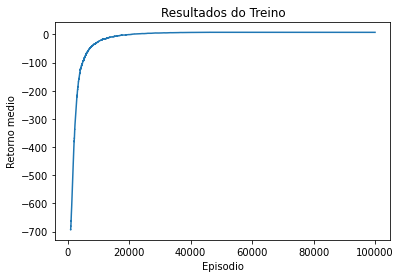

In [6]:
d = pd.Series(returns_list)

plt.plot(d.rolling(1000).mean()) #usa pandas para calcular media movel
plt.xlabel('Episodio')
plt.ylabel('Retorno medio')
plt.title('Resultados do Treino')
plt.show()